## Week7 bonus descriptions

Here are some cool mini-projects you can try to dive deeper into the topic.

## Implement attention (5+++ pts)

Some seq2seq tasks can benefit from the attention mechanism. In addition to taking the _last_ time-step of encoder hidden state, we can allow decoder to peek on any time-step of his choice.

![img](https://xiandong79.github.io/downloads/nmt-model-fast.gif)

```



```
### Copy  functions from practice notebook and prepare vocabulary.

In [20]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
# If True, only translates phrases shorter than 20 characters (way easier).
EASY_MODE = False
MODE = "he-to-en"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20
REPORT_FREQ = 500                          # how often to evaluate validation score

In [3]:
import editdistance  # !pip install editdistance
from basic_model_torch import*
import random
from voc import Vocab
from collections import defaultdict
from IPython.display import clear_output
from tqdm import tqdm, trange  # or use tqdm_notebook,tnrange

def get_voc(MODE):
    word_to_translation = defaultdict(list)  # our dictionary
    bos = '_'
    eos = ';'
    with open("main_dataset.txt", encoding="utf-8") as fin:
        for line in fin:
            en, he = line[:-1].lower().replace(bos, ' ').replace(eos, ' ').split('\t')
            word, trans = (he, en) if MODE == 'he-to-en' else (en, he)
            if len(word) < 3:
                continue
            if EASY_MODE:
                if max(len(word), len(trans)) > 20:
                    continue
            word_to_translation[word].append(trans)
    print("size = ", len(word_to_translation))
    # get all unique lines in source language
    all_words = np.array(list(word_to_translation.keys()))
    # get all unique lines in translation language
    all_translations = np.array(
        [ts for all_ts in word_to_translation.values() for ts in all_ts])


    inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
    out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')
    return all_words, all_translations, word_to_translation, inp_voc, out_voc


def translate(lines, max_len=MAX_OUTPUT_LENGTH):
    """
    You are given a list of input lines.
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)
    lines_ix = torch.tensor(lines_ix, dtype=torch.int64, device=device)
    # Compute translations in form of indices
    trans_ix = model.translate(lines_ix, greedy=True, max_len=max_len)[0]
    # Convert translations back into strings
    return out_voc.to_lines(trans_ix.data.cpu().numpy())



def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references) != 0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)


def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words, np.ndarray)
    batch_words = np.random.choice(words, size=bsize, replace=False)
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    return np.array(distances, dtype='float32')



def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    # choose words
    batch_words = np.random.choice(words, size=batch_size)
    # choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))
    return batch_words, batch_trans



def compute_loss_on_batch(input_sequence, reference_answers):
    """ Compute crossentropy loss given a batch of sources and translations """
    input_sequence = torch.tensor(inp_voc.to_matrix(input_sequence), dtype=torch.int64, device=device)
    reference_answers = torch.tensor(out_voc.to_matrix(reference_answers), dtype=torch.int64, device=device)

    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq =  model.forward(input_sequence,reference_answers)

    # compute elementwise crossentropy as negative log-probabilities of reference_answers.
    crossentropy = - torch.sum(logprobs_seq * to_one_hot(reference_answers, len(out_voc)), dim=-1)
    assert crossentropy.dim(
    ) == 2, "please return elementwise crossentropy, don't compute mean just yet"
    # average with mask
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    loss = torch.sum(crossentropy * mask) / torch.sum(mask)
    return loss



In [4]:
all_words, all_translations, word_to_translation, inp_voc, out_voc = get_voc(MODE)

size =  181801


In [5]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(
        all_words, test_size=0.1, random_state=42)

In [6]:
val_words = test_words[:5000]
test_words = test_words[5000:]
print(val_words.shape)
print(test_words.shape)

(5000,)
(13181,)


```

```

### Attentive module

Defined in **"attentive_model.py"**

In [7]:
from attentive_model import AttentiveModel

In [8]:
model = AttentiveModel(inp_voc, out_voc,emb_size=64, hid_size=256, attn_size=160).to(device)
# Play around with symbolic_translate and symbolic_score
inp = torch.tensor(np.random.randint(0, 10, [3, 5]), dtype=torch.int64).cuda()
out = torch.tensor(np.random.randint(0, 10, [3, 5]), dtype=torch.int64).cuda()

# translate inp (with untrained model)
sampled_out, logp = model.translate(inp, greedy=False)

print("Sample translations:\n", sampled_out.shape)
print("Log-probabilities at each step:\n", logp.shape)

Sample translations:
 torch.Size([3, 142])
Log-probabilities at each step:
 torch.Size([3, 142, 325])


llh=0.808, mean score=7.830


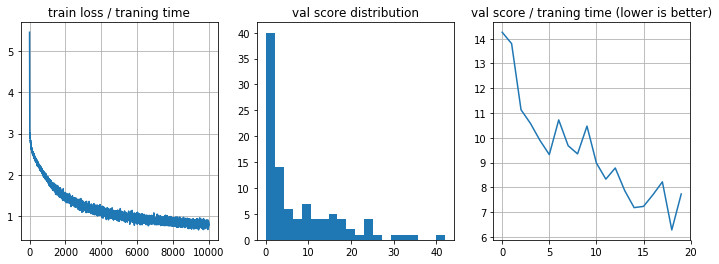

100%|██████████| 10000/10000 [25:57<00:00,  6.42it/s]


In [9]:
loss_history = []
editdist_history = []
entropy_history = []
model_state = model.state_dict()
best_score = 0
opt = torch.optim.Adam(model.parameters())
model.train()

for i in trange(10000):
    loss = compute_loss_on_batch(*sample_batch(train_words, word_to_translation, 256))

    # train with backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(val_words)
        if np.mean(current_scores) > best_score:
            model_state = model.state_dict()
        editdist_history.append(current_scores.mean())
        print("llh=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(133)
        plt.title('val score / traning time (lower is better)')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        
model.load_state_dict(model_state)

llh=0.738, mean score=7.753


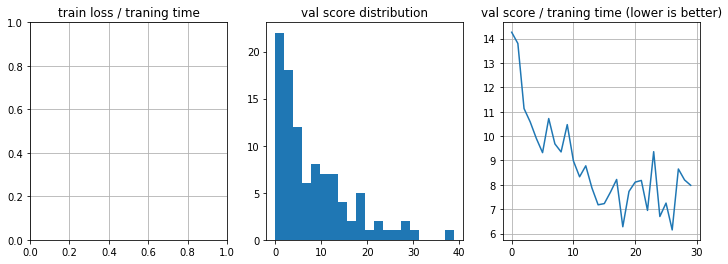

100%|██████████| 5000/5000 [13:03<00:00,  6.38it/s]


In [12]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()

for i in trange(10000):
    loss = compute_loss_on_batch(*sample_batch(train_words, word_to_translation, 256))

    # train with backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(val_words)
        if np.mean(current_scores) > best_score:
            model_state = model.state_dict()
        editdist_history.append(current_scores.mean())
        print("llh=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('train loss / traning time')
      
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(133)
        plt.title('val score / traning time (lower is better)')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        
model.load_state_dict(model_state)

In [14]:
torch.save(model.state_dict(), "attentive_model.state_dict")

### Result

In [13]:
test_scores = []
model.eval()
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)

print("Supervised test score:", np.mean(test_scores))

100%|██████████| 412/412 [00:14<00:00, 28.93it/s]

Supervised test score: 7.30066004096806


### SCST

In [15]:
def compute_reward(input_sequence, translations):
    """ computes sample-wise reward given token ids for inputs and translations """
    distances = list(map(get_distance,
                         inp_voc.to_lines(input_sequence.data.cpu().numpy()),
                         out_voc.to_lines(translations.data.cpu().numpy())))
    # use negative levenshtein distance so that larger reward means better policy
    return - torch.tensor(distances, dtype=torch.float)

In [18]:
def scst_objective_on_batch(input_sequence, max_len=MAX_OUTPUT_LENGTH):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    input_sequence = torch.tensor(inp_voc.to_matrix(input_sequence), dtype=torch.int64, device=device)

    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp =  model.translate(input_sequence, greedy=False, max_len=max_len)
    # use model to __greedy__ symbolic translations given input_sequence
    greedy_translations, greedy_logp =  model.translate(input_sequence, greedy=True, max_len=max_len)

    # compute rewards and advantage
    rewards = compute_reward(input_sequence, sample_translations)
    baseline = compute_reward(input_sequence, greedy_translations)

    # compute advantage using rewards and baseline
    advantage = rewards - baseline

    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logp_sample = torch.sum(sample_logp * to_one_hot(sample_translations, len(out_voc)), dim=-1)
    
    # ^-- hint: look at how crossentropy is implemented in supervised learning loss above
    # mind the sign - this one should not be multiplied by -1 :)

    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    J = logp_sample * advantage[:, None]

    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    # average with mask
    mask = infer_mask(sample_translations, out_voc.eos_ix)
    loss = - torch.sum(J * mask) / torch.sum(mask)

    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
    entropy = - torch.sum(torch.exp(sample_logp)*sample_logp, -1)
    # hint: you can get sample probabilities from sample_logp using math :)

    assert entropy.dim(
    ) == 2, "please make sure elementwise entropy is of shape [batch,time]"

    reg = - 0.01 * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

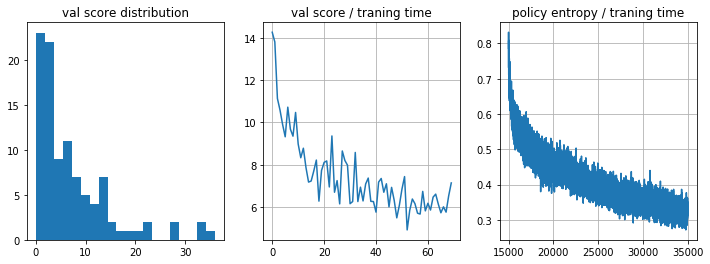

100%|██████████| 20000/20000 [58:27<00:00,  5.70it/s]

J=-0.396, mean score=6.243


In [21]:
entropy_history = [np.nan] * len(loss_history)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in trange(20000):
    loss, ent = scst_objective_on_batch(
        sample_batch(train_words, word_to_translation, 256)[0])  # [0] = only source sentence

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())
    entropy_history.append(ent.item())

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(132)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.subplot(133)
        plt.title('policy entropy / traning time')
        plt.plot(entropy_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))

In [22]:
torch.save(model.state_dict(), "scst_attentive_model.state_dict")

In [23]:
test_scores = []
model.eval()
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)

print("Test score:", np.mean(test_scores))

100%|██████████| 412/412 [00:11<00:00, 34.73it/s]

Test score: 6.396934982171307


**Result even with one LSTM cell and attention is better than for previous architecture without attention.**

```




```
## Actor-critic (5+++ pts)

While self-critical training provides a large reduction of gradient variance, it has a few drawbacks:
- It requires a lot of additional computation during training
- It doesn't adjust V(s) between decoder steps. (one value per sequence)

There's a more general way of doing the same thing: learned baselines, also known as __advantage actor-critic__.

There are two main ways to apply that:
- __naive way__: compute V(s) once per training example.
  - This only requires additional 1-unit linear dense layer that grows out of encoder, estimating V(s)
  - (implement this to get main points)
- __every step__: compute V(s) on each decoder step
  - Again it's just an 1-unit dense layer (no nonlinearity), but this time it's inside decoder recurrence.
  - (+3 pts additional for this guy)

In both cases, you should train V(s) to minimize squared error $(V(s) - R(s,a))^2$ with R being actual levenshtein.
You can then use $ A(s,a) = (R(s,a) - const(V(s))) $ for policy gradient.

There's also one particularly interesting approach (+5 additional pts):
- __combining SCST and actor-critic__:
  - compute baseline $V(s)$ via self-critical sequence training (just like in main assignment)
  - learn correction $ C(s,a_{:t}) = R(s,a) - V(s) $ by minimizing $(R(s,a) - V(s) - C(s,a_{:t}))^2 $
  - use $ A(s,a_{:t}) = R(s,a) - V(s) - const(C(s,a_{:t})) $


```









```
###  Something goes wrong here

```









```

### Modify objective function (change advantage, add value loss).

In [8]:
def actor_critic_objective_on_batch(input_sequence, max_len=MAX_OUTPUT_LENGTH, policy_loss=True):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    input_sequence = torch.tensor(inp_voc.to_matrix(input_sequence), dtype=torch.int64, device=device)
    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp, values =  model.translate(input_sequence, greedy=False, max_len=max_len)
    length = sample_translations.shape[1]
    # mask
    mask = infer_mask(sample_translations, out_voc.eos_ix)
    N = torch.sum(mask)
    rewards = compute_reward(input_sequence, sample_translations)   
    advantage = rewards.unsqueeze(1) - values # shape = [batch, seq_length]
    loss = 0
    entropy_loss = np.nan
    value_loss = torch.sum(advantage**2 * mask) / N
    loss += value_loss
    if policy_loss:
        # compute log_pi(a_t|s_t), shape = [batch, seq_length]
        logp_sample = torch.sum(sample_logp * to_one_hot(sample_translations, len(out_voc)), dim=-1)
        J = logp_sample * advantage.detach()
        policy_loss = - torch.sum(J * mask) / N
        # regularize with negative entropy. Don't forget the sign!
        # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
        entropy = - torch.sum(torch.exp(sample_logp)*sample_logp, -1)
        entropy_loss = torch.sum(entropy * mask) / N
        loss += policy_loss
        loss -= 0.01 * entropy_loss
    
    
    return loss, entropy_loss


### Load Attentive Actor Critic Model

Defined in **"attentive_model.py"**

Model predicts values after each decoder step. So `translate` method returns also values of shape `[batch, seq_length]`

In [9]:
from attentive_model import AttentiveActorCriticModel

In [12]:
model = AttentiveActorCriticModel(inp_voc, out_voc,emb_size=64, hid_size=256, attn_size=160).to(device)

### Train

llh=1.344, mean score=12.515


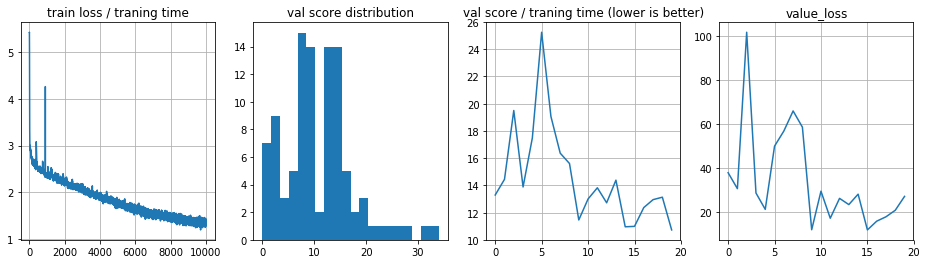

100%|██████████| 10000/10000 [38:28<00:00,  4.33it/s]


In [13]:
loss_history = []
value_loss_history = []
editdist_history = []
entropy_history = []
model_state = model.state_dict()
best_score = 0
opt = torch.optim.Adam(model.parameters())
model.train()

for i in trange(10000):
    loss = compute_loss_on_batch(*sample_batch(train_words, word_to_translation, 256))
    value_loss, ent = actor_critic_objective_on_batch(sample_batch(train_words, word_to_translation, 32)[0],
                                               policy_loss = False)

    # train with backprop
    (loss+0.05*value_loss).backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())


    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(val_words)
        if np.mean(current_scores) > best_score:
            model_state = model.state_dict()
        editdist_history.append(current_scores.mean())
        value_loss_history.append(value_loss.item())
        print("llh=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))
        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(142)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(143)
        plt.title('val score / traning time (lower is better)')
        plt.plot(editdist_history)
        plt.grid()
        plt.subplot(144)
        plt.title('value_loss')
        plt.plot(value_loss_history)
        plt.grid()
        plt.show()
        
model.load_state_dict(model_state)

llh=1.191, mean score=12.027


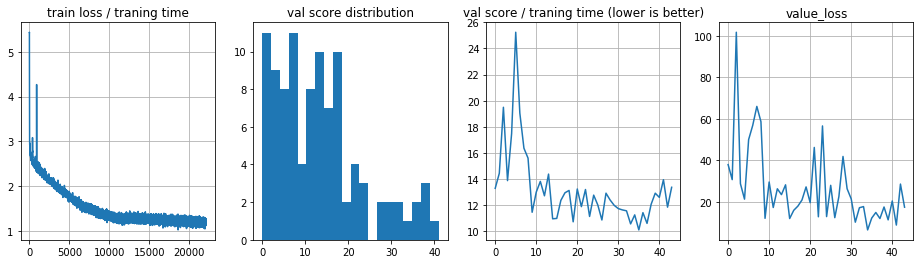

100%|██████████| 10000/10000 [38:48<00:00,  4.29it/s]


In [15]:
opt = torch.optim.Adam(model.parameters())

for i in trange(10000):
    loss = compute_loss_on_batch(*sample_batch(train_words, word_to_translation, 256))
    value_loss, ent = actor_critic_objective_on_batch(sample_batch(train_words, word_to_translation, 32)[0],
                                               policy_loss = False)

    # train with backprop
    (loss+0.1*value_loss).backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())


    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(val_words)
        if np.mean(current_scores) > best_score:
            model_state = model.state_dict()
        editdist_history.append(current_scores.mean())
        value_loss_history.append(value_loss.item())
        print("llh=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))
        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(142)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(143)
        plt.title('val score / traning time (lower is better)')
        plt.plot(editdist_history)
        plt.grid()
        plt.subplot(144)
        plt.title('value_loss')
        plt.plot(value_loss_history)
        plt.grid()
        plt.show()
        
model.load_state_dict(model_state)

In [16]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
opt.zero_grad()
# REPORT_FREQ = 100
# entropy_history = [np.nan] * len(loss_history)
model.eval()

AttentiveActorCriticModel(
  (emb_inp): Embedding(196, 64)
  (emb_out): Embedding(325, 64)
  (dec_start): Linear(in_features=512, out_features=512, bias=True)
  (logits): Linear(in_features=256, out_features=325, bias=True)
  (encoder): LSTMCell(64, 256)
  (decoder): LSTMCell(320, 256)
  (attn): AttentionLayer(
    (nonlinearity): Tanh()
    (lin_enc): Linear(in_features=256, out_features=160, bias=True)
    (lin_dec): Linear(in_features=256, out_features=160, bias=True)
    (lin_out): Linear(in_features=160, out_features=1, bias=True)
    (drop): Dropout(p=0.6)
  )
  (drop): Dropout(p=0.5)
  (value): Linear(in_features=256, out_features=1, bias=True)
)

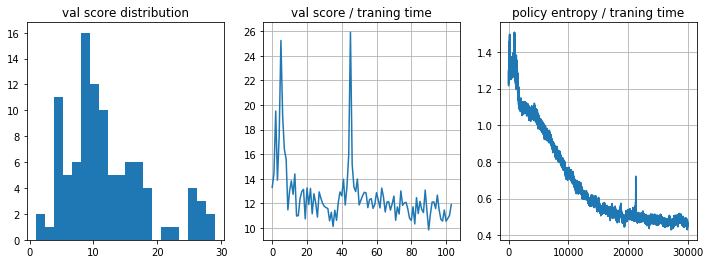

100%|██████████| 30000/30000 [1:00:05<00:00,  8.32it/s]

J=8.862, mean score=11.272


In [17]:
for i in trange(30000):
    loss, ent = actor_critic_objective_on_batch(
        sample_batch(train_words, word_to_translation, 256)[0])  # [0] = only source sentence

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())
    entropy_history.append(ent.item())

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(132)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.subplot(133)
        plt.title('policy entropy / traning time')
        plt.plot(entropy_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))

### Result

In [ ]:
test_scores = []
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)

print("Test score:", np.mean(test_scores))

## More metrics: BLEU (5+ pts)

Pick BLEU or any other relevant metric, e.g. BLEU (e.g. from `nltk.bleu_score`).
* Train model to maximize BLEU directly
* How does levenshtein behave when maximizing BLEU and vice versa?
* Compare this with how they behave when optimizing likelihood. 

(use default parameters for bleu: 4-gram, uniform weights)